# ARIMA models

Arima models fall into two categories:

1. **Non-seasonal ARIMA model**

- When there are no seasons in our time series data set (a season could be a period of time where we have a certain trend).

2. **Seasonal Arima model**

- Seasons in our time series data set.


This can be seen by doing a seasonal decomposition of our data (function in python).

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import datetime

In [39]:
# arima model in python

ticker          = 'AMZN'
mystock         = yf.Ticker(ticker)
historical_data = mystock.history(period = '10y')
historical_data

historical_data.to_csv('AMZN_saved.csv')

In [7]:
historical_data = pd.read_csv('AMZN_saved', index_col = [0])
historical_data.index = pd.to_datetime(historical_data.index)

C:\Users\Ricardo\AppData\Local\Temp\ipykernel_8752\1218390122.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  historical_data.index = pd.to_datetime(historical_data.index)


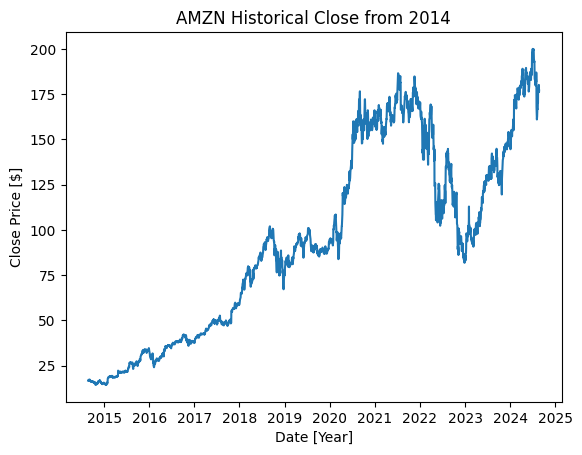

In [8]:
plt.plot(historical_data.index, historical_data['Close'])
plt.title('AMZN Historical Close from 2014')
plt.ylabel('Close Price [$]')
plt.xlabel('Date [Year]')
plt.show()

Because an ARIMA model requires stationarity, then we can apply an ADF test to determine if the time series is stationary or not. Clearly by looking at the above plot, it is not stationary since the mean is not constant over time. Variance also does not seem to be constant over time.

Stationarity means:

- Constant mean and variance (or almost constant).


### Augmented Dickey Fuller (ADF) Test:

To begin understanding a Augmented Dickey Fuller test, we need to understand certain concepts such as a **random walk** and **stationarity**.

1. **Random Walk:**

- A random walk is a stochastic process in which the current value is characterized by a random error ($\epsilon$), and also depending on the previous value. That is to say that we have the following process (not i.i.d. since it depends on the previous value).

$$y_{t} = y_{t-1} + \epsilon_t$$

*Where a time series is a unit root if it includes a random walk.*

2. **Stationarity:**

- This means that the mean (expectation) and variance is constant over time. That is to say that a time series' properties do not depend on the time is it observed. Clearly, time series data sets such as OHLC historical data is not stationary since these values tend to either go up or down over time and may be more sporadic as time passes.

- Doing a seasonal decomposition can help us in understanding why there is no stationarity in a data set (or otherwise) since it separates the series into:
    - Observed.
    - Trend.
    - Seasonal.
    - Residuals.

- It may be that during a season, it is stationary. Therefore applying an ARIMA model during an identified season may work.

Finally, a **unit root** is of the following form:

$$Y_{t} = \alpha Y_{t-1} + \beta X_{e} + \epsilon$$

Which means that we are testing against (null hypothesis) it being a unit root (it depending on a previous value *also called the lag*).


The **Dickey Fuller Test** expands the unit root test to include also a lag and the difference of the series at a certain time (t-1).

$$y_{t} = c + \beta t + \alpha y_{t-1} + \phi \Delta Y_{t-1} + e_{t}$$


Then the ***Augmented Dickey Fuller Test*** expands this to include higher order differences ($\phi_{p}\Delta Y_{t-p}$) to obtain the following:



$$\boxed{y_{t} = c + \beta t + \alpha y_{t-1} + \sum^{P}_{\mathbb{p}} \phi \Delta Y_{t-\mathbb{p}} + e_{t}}$$


Then using the above equation we want to reject the null hypothesis that there is a unit root, to conclude that the series is stationary.

$$
\;\\
\;\\
H_{0}: \;\; \alpha = 1 \quad \rightarrow \text{Time series has a unit root.}\\

H_{1}: \;\; \alpha \neq 1 \quad \rightarrow \text{Time series is stationary (does not have a unit root).}

$$

*We want to obtain a p-value less than the (1-significance level) we are testing for in order to say whether or not we reject that null on that significance level.* For example a p-value of less than 0.05 means we are confident that at the 95% confidence level, we can reject the null that the time series has a unit root.


References used:

- [Augmented Dickey Fuller Test.](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/)
- [Stationarity of a Time series. (Forecasting: Principles and Practice ebook)](https://otexts.com/fpp2/stationarity.html)
- [Decomposing Time series data trend and seasonality.](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)

Applying the ADF test on the AMZN close prices we can see whether we can reject the null that the series is non-stationary.

In [30]:
from statsmodels.tsa.stattools import adfuller

# Code taken from the documentation
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    
    # print(dfoutput)

    return dfoutput

adf_result = adf_test(historical_data['Close'])
print(adf_result)

Results of Dickey-Fuller Test:
Test Statistic                   -0.829186
p-value                           0.810398
#Lags Used                       27.000000
Number of Observations Used    2489.000000
Critical Value (1%)              -3.432980
Critical Value (5%)              -2.862702
Critical Value (10%)             -2.567389
dtype: float64


Lets look at the above results, using a lag of 27 (meaning that our data depends on a lag of 27). The p-value obtained was a 0.8. Therefore it is too high to reject the null at a decent confidence level (not even a 90% confidence level since we would need a p-value of 0.1) since the p-value is $0.8> 0.05, 0.1,0.15$.

**We can then conclude that we cannot reject the null hypothesis that our series of observations are non stationary (this means they are non stationary)**

### Methods to combat non stationarity.


Differencing is something that we can use in order to reduce the non stationarity in our data. This is usually done by taking the difference between the current and previous value.

- Returns (calculated as percent change) is a type of differencing that changes the close values into the returns. **This is stationary.**
- Log returns (Difference between the log of the current value and the previous value). **This is also stationary.**

Something that happens when we apply differencing, is that we lose memory. That means that we don't see trends in our data since we are just simply finding the difference between two values.

According to Marcos Lopez de Prado *[1]*, there is a way of having a tradeoff between memory and stationarity, which is a "necessary, but not strict" condition for high performance of an ML algorithm. It may be that our performance improves when we maintain some sort of memory as opposed to having just a stationary series (where we remove all memory). This requires a different kind of differencing.

*[1]*: "Advanced in Financial Machine Learning". Marcos Lopez de Prado.

We can look at an example of changing the non-stationary series to a stationary series. Taking the AMZN stock close price and comparing it to the returns calculated as the percentage change, we can check what a non-stationary and stationary dataset looks like.

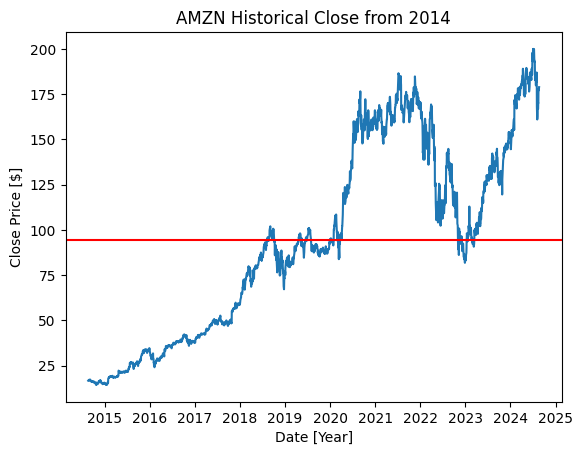

Results of Dickey-Fuller Test:
p-value: 0.8243360175684671


In [5]:
#non-stationary series

plt.plot(historical_data.index, historical_data['Close'])
plt.title('AMZN Historical Close from 2014')
plt.axhline(np.mean(historical_data['Close']), color='red')
plt.ylabel('Close Price [$]')
plt.xlabel('Date [Year]')
plt.show()

adf_nonstat = adf_test(historical_data['Close'])

print("p-value: {}".format(adf_nonstat['p-value']))

Obtaining the return of AMZN close prices.

C:\Users\Ricardo\AppData\Local\Temp\ipykernel_7288\739573765.py:3: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  return_df.index = pd.to_datetime(return_df.index)


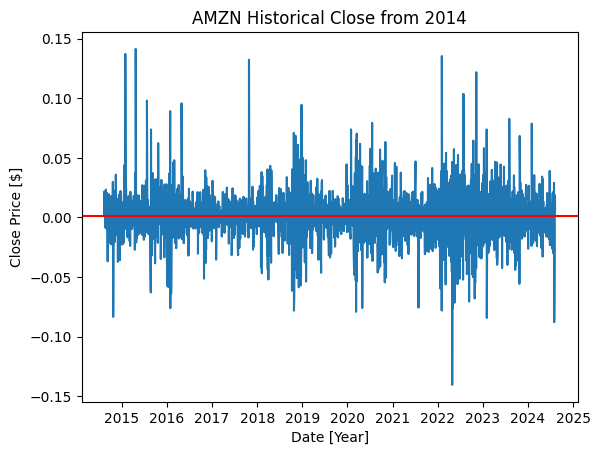

Results of Dickey-Fuller Test:
p-value: 7.829954393357203e-30


In [6]:
# returns dataset calculated before
return_df       = pd.read_csv("return_df.csv", index_col = [0])
return_df.index = pd.to_datetime(return_df.index)

plt.plot(return_df.index, return_df['AMZN'])
plt.title('AMZN Historical Close from 2014')
plt.axhline(np.mean(return_df['AMZN']), color='red')
plt.ylabel('Close Price [$]')
plt.xlabel('Date [Year]')
plt.show()
adf_stat = adf_test(return_df['AMZN'])
print("p-value: {}".format(adf_stat['p-value']))

Notice the difference in the p values. For the stationary dataset we have a p-value in the order of magnitude of $10^{-30}$, meanwhile for the non-stationary series we have a p-value of $0.82$. Therefore we have a higher significance level than 99% in our stationary data set, showing that we have enough evidence to reject the null hypothesis that a root unit exists in our series at a higher than 99% confidence level. Meanwhile for the non-stationary series we cannot reject thenull at a well enough significance level.

# Arima Model

Now that we understand the stationarity vs. non stationarity concept and also the ADF test for stationarity, we can continue onto the ARIMA model.

ARIMA stands for AutoRegressive, Integration, Moving Average.

To begin, we should first start with the AutoRegressive part.

### AutoRegressive model (AR(p) model):

An autoregresive model is of the following form (**with order p**):

$$y_{t} = c+\sum_{p}^{P}\phi_{p}y_{t-p} +  \epsilon_{t}$$

This means that we are forecasting the variable of interest using a *linear combination of past values* where the $\phi_{p}$ is just the parameter assigned to each of the lagged values (previous values in the model). $\epsilon$ is just the white noise and c is a drift (shift in the regression line).

- Notice how we have an **order p**. Important for the ARIMA model

### Moving average models (MA(q) model):

Instead of using the past values of our forecast variable, we are going to use the **past errors**.

$$y_{t} = c+\epsilon_t + \sum^{Q}_{q} \theta_{q}\epsilon_{t-q}$$


Notice how we have an **order q**, which will be important later for the ARIMA model.

## Non-seasonal ARIMA model:

- The non-seasonal ARIMA model is used when we have no seasons (we should first do a seasonal decomposition of the data to see this).

Combining the following we can get a ARIMA model:

1. Differencing
2. Autoregression
3. Moving Average

Where we have the model ARIMA $(p, d, q)$ from the previously explained models:

- p = order of the autoregressive part
- d = degree of first differencing involved
- q = order of the moving average part

#### How to choose the p and q values?

The p and q values are chosen according to the ACF (Autocorrelation plots) and also the PACF (partial autocorrelation plot). 

1. **Autocorrelation (use for the q of MA)**:

- This plot shows the autocorrelations which measures the relationship between the $y_{t}$ and the $y_{t-k}$ for k lags. Therefore we have that the plot on the:

    - y-axis: autocorrelation value
    - x-axis: lag
- In this case we want to know, until how many lags does our current value in the series stops being correlated to the lagged value (until an acceptable measure at least, zero corelation may be impossible).

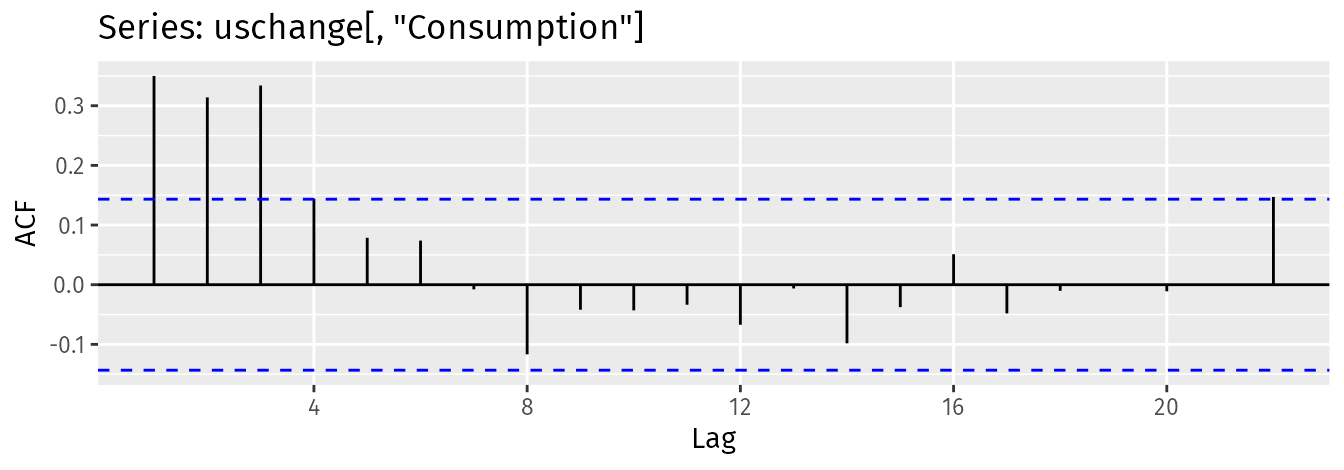

The problem with this is that we don't exactly see the correlation between each individual lag since we are still including each lag in the correlation.

2. **Partial Autocorrelation (use for the p of AR)**:

To change this we see the individual relationships between $y_{t}$ and $y_{t-k}$ for each k to removing the effects of the other lags not in question.

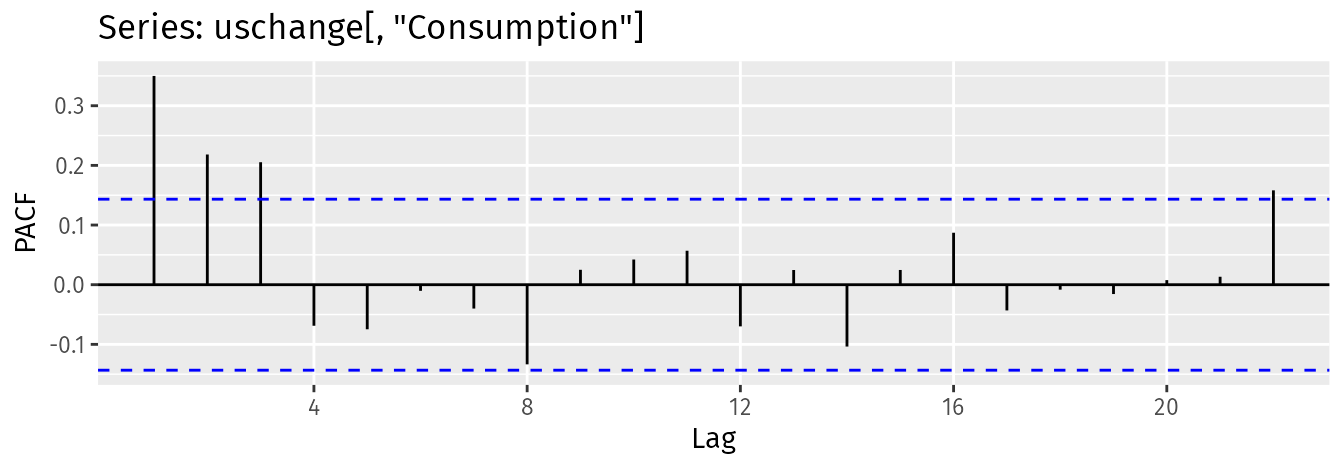


Note that in order to choose the actual values of p, d, and q we must do the following:

1. **parameter $\mathbb{p}$ (AR order)**

- Use the lag number after which the PACF plot shows a significant drop.


2. **parameter $\mathbb{d}$ (Differencing order)**

- Using the ADF test we can apply differencing until we obtain a good p-value (until it become stationary).

3. **parameter $\mathbb{q}$ (MA order)**

- Use the ACF plot and look at the lag number *after* which it shows a significant drop.

***Lets look at an example:***

- Using the close data used before we will apply the differencing until we have a good enough p-value.


    - Here we do a differencing of 1, where we do this by just subtracting the current value by the previous value.

Non-stationary Close data................

Results of Dickey-Fuller Test:
Test Statistic                   -0.829186
p-value                           0.810398
#Lags Used                       27.000000
Number of Observations Used    2489.000000
Critical Value (1%)              -3.432980
Critical Value (5%)              -2.862702
Critical Value (10%)             -2.567389
dtype: float64


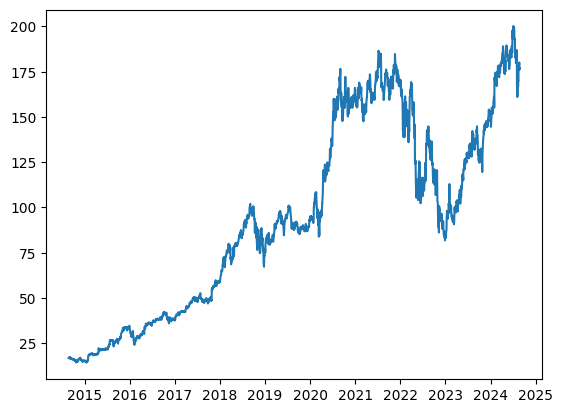


Differencing of 1 applied................

Results of Dickey-Fuller Test:
Test Statistic                -1.062540e+01
p-value                        5.381189e-19
#Lags Used                     2.600000e+01
Number of Observations Used    2.488000e+03
Critical Value (1%)           -3.432981e+00
Critical Value (5%)           -2.862702e+00
Critical Value (10%)          -2.567389e+00
dtype: float64


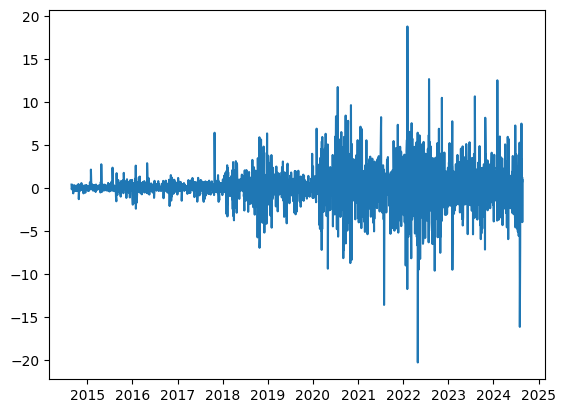

In [36]:
# close data:
close_data = historical_data['Close']

print("Non-stationary Close data................\n")
print(adf_test(close_data))
plt.plot(close_data.index, close_data)
plt.show()

# differencing once:
diff1 = (close_data-close_data.shift(1))[1:]

print("\nDifferencing of 1 applied................\n")
print(adf_test(diff1[1:]))
plt.plot(close_data.index[1:], diff1)
plt.show()

Figuring out the MA order (q)

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Notice how we use the differenced dataset since we want to apply the autoregressive / moving average model into the differenced data

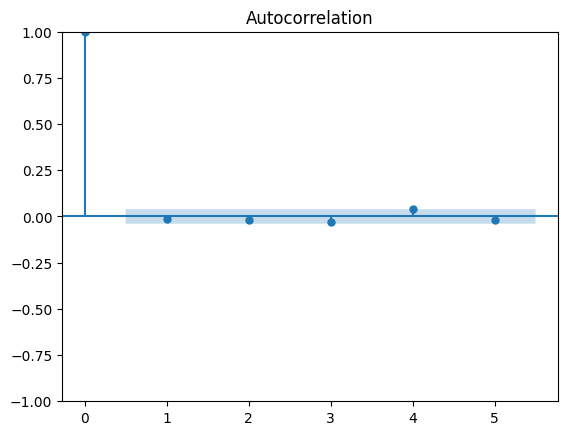

In [37]:
plot_acf(diff1[1:], lags = 5)
# Use plt.show() to not plto two of the same.
plt.show()

We can see that at a lag of 1, we have a significant decrease. Therefore our q should be equal to 0.

Lets find the p parameter from the AR model.

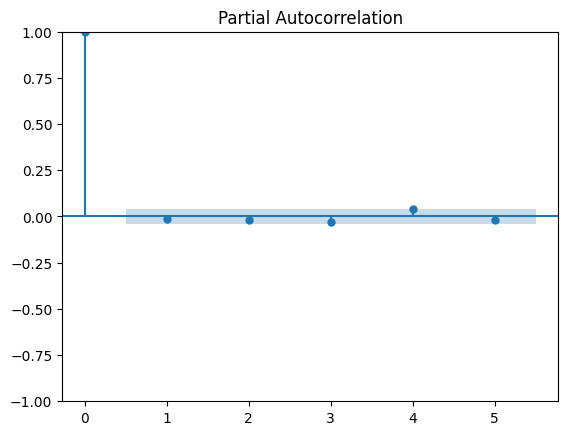

In [38]:
plot_pacf(diff1[1:],lags = 5)
plt.show()

Clearly, the lag is equal to 1 for a small pacf value. Lets use the p parameter as 0.

We now have $d = 1, p = 0, q = 0$.

We can now fit an ARIMA model.

In [34]:
from statsmodels.tsa.arima.model import ARIMA

In [37]:
# Fitting an ARIMA model

model = ARIMA(close_data, order = (0,1,0))# p,d,q order
model_fit = model.fit()

c:\Users\Ricardo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ricardo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ricardo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ricardo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary

In [38]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2516
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5601.658
Date:                Wed, 21 Aug 2024   AIC                          11209.315
Time:                        14:32:05   BIC                          11226.806
Sample:                             0   HQIC                         11215.663
                               - 2516                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9097      0.084     10.880      0.000       0.746       1.074
ma.L1         -0.9217      0.078    -11.844      0.000      -1.074      -0.769
sigma2         5.0365      0.059     84.770      0.000       4.920       5.153
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9470.70
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              30.91   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
predictions = model_fit.predict(start=0, end=len(close_data)-1, dynamic=False)
forecast_steps = 10  # Number of steps to forecast
forecast = model_fit.forecast(steps=forecast_steps)

c:\Users\Ricardo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Ricardo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [45]:
forecast_errors = predictions-close_data[1:]

Lets make a plot of how well it predicted the time series.

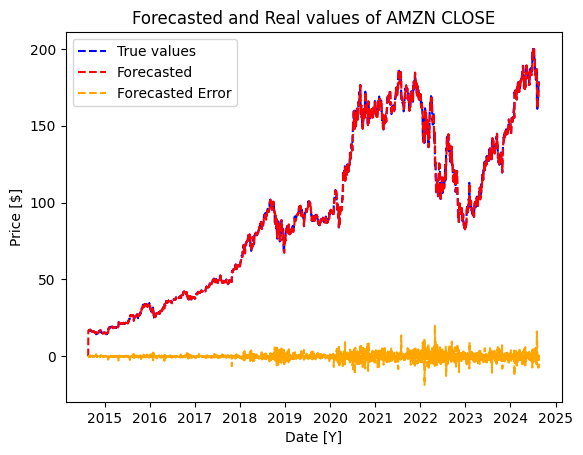

In [49]:
plt.plot(close_data.index, close_data, color='blue', linestyle='dashed', label = 'True values')
plt.plot(close_data.index, predictions, linestyle='dashed', color = 'red',label='Forecasted')

plt.plot(close_data.index, forecast_errors, linestyle='dashed', color = 'orange',label='Forecasted Error')
plt.ylabel('Price [$]')
plt.xlabel('Date [Y]')
plt.title('Forecasted and Real values of AMZN CLOSE')
plt.legend()
plt.show()

## Performance Comparison between Machine Learning Models:

The models we will be comparing are the Random Forest Regressor and a Recurrent Neural Network in Pytorch.

## Seasonal ARIMA model

With the seasonal ARIMA model we need to now take into account seasons in our time series. It may be that there are yearly trends in our series which may be more suitable to contain an extra seasonal factor in our ARIMA model. Of course, if our data has a trend or a seasonal trend it may be that it is not stationary.

Firstly lets look at the seasonal decomposition of our AMZN time series.


Types of seasons:

1. Additive seasons:

$$y_{t} = \text{Level} + \text{Trend} + \text{Seasonality} + \text{Noise}$$


- Trends / changes over time appear consistently by the same amount (Store sales every year are additive since we know the dates of certain sales in the stores (Black Friday, Christmas, New Years, Summer Sales))

2. Multiplicative Seasons:

$$y_{t} = \text{Level} \cdot \text{Trend} \cdot \text{Seasonality} \cdot \text{Noise}$$

- The changes are not constant and they increase or decrease over time.

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [12]:
historical_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-08-25 00:00:00-04:00,16.660500,16.838499,16.635500,16.701000,39154000,0.0,0.0
2014-08-26 00:00:00-04:00,16.850000,17.218000,16.727501,17.091499,73094000,0.0,0.0
2014-08-27 00:00:00-04:00,17.104500,17.333500,17.066999,17.159000,59232000,0.0,0.0
2014-08-28 00:00:00-04:00,17.000000,17.089500,16.940001,17.000999,45054000,0.0,0.0
2014-08-29 00:00:00-04:00,17.087999,17.091000,16.884001,16.952000,38790000,0.0,0.0
...,...,...,...,...,...,...,...
2024-08-19 00:00:00-04:00,177.639999,178.300003,176.160004,178.220001,31129800,0.0,0.0
2024-08-20 00:00:00-04:00,177.919998,179.009995,177.429993,178.880005,26255200,0.0,0.0
2024-08-21 00:00:00-04:00,179.919998,182.389999,178.889999,180.110001,35599100,0.0,0.0


Because we are working with Stock market data, there are 250 trading days in a year. Therefore it is best to use this period. The model can either be additive or multiplicative.

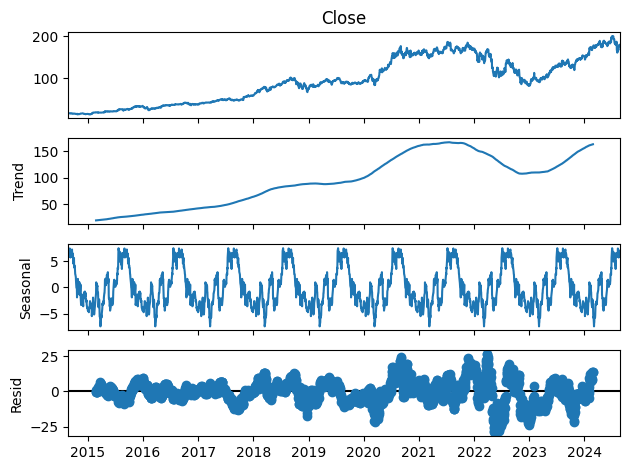

In [28]:
result = seasonal_decompose(historical_data['Close'], model='additive', period=250)
result.plot()
plt.show()

Looking at the Seasonal component we can clearly identify that there are trends every year (repeating the same trends.)